# DecisionTreeClassifier

Un árbol de decisión es un modelo muy simple, intuitivo e interpretable. Resulta muy útil analizar sus resultados para detectar predictores fuertes y features irrelevantes, para poder afinar los preprocessings de modelos más complejos y mejorar su eficiencia. Se entrenaron dos árboles de decisión con preprocessings distintos: uno más sencillo y otro más sofisticado.

In [36]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
import pandas as pd
import numpy as np
from joblib import dump, load
from scoring import *
pd.set_option('display.max_rows', 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing Nº1

In [2]:
formaforma
df_features = dummy(df_features, [
    "direccion_viento_tarde",
    "direccion_viento_temprano",
    "rafaga_viento_max_direccion",
    "barrio"
])

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)
imputer = SimpleImputer()
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Grid search de hiperparámetros

In [3]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(3,15,1),
    "min_samples_leaf": np.arange(100,800,25),
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8509136763607907

In [6]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.852851,0.839387,0.70466,0.48647,0.575581


In [9]:
grid_history_table(grid)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,gini,11,150,0.850914,0.837009,0.705018,0.469346,0.563054
1,gini,12,150,0.850904,0.837009,0.705018,0.469346,0.563054
2,gini,13,175,0.850888,0.836603,0.700469,0.474515,0.564984
3,gini,10,150,0.850852,0.837009,0.705018,0.469346,0.563054
4,gini,11,175,0.850822,0.836603,0.700469,0.474515,0.564984
...,...,...,...,...,...,...,...,...
667,gini,3,500,0.787686,0.827854,0.736649,0.362186,0.484594
668,gini,3,400,0.787681,0.827854,0.736649,0.362186,0.484594
669,gini,3,325,0.787671,0.827854,0.736649,0.362186,0.484594
670,gini,3,350,0.787655,0.827854,0.736649,0.362186,0.484594


Vemos que los mejores modelos utilizaron ***gini*** como criterio de separación. Esto es interesante, ya que generalmente el criterio ***entropy*** suele dar mejores resultados

### Importancia de cada feature

In [12]:
feature_importances(df_features.columns, grid.best_estimator_.feature_importances_).head(10)

,importancia
feature,
humedad_tarde,0.628853
mm_lluvia_dia,0.094982
rafaga_viento_max_velocidad,0.083640
presion_atmosferica_tarde,0.077140
horas_de_sol,0.054424
temperatura_temprano,0.013794
nubosidad_tarde,0.012390
humedad_temprano,0.006243
temperatura_tarde,0.006027


Las features que el modelo considero más importantes coinciden con las analizadas en el TP1

In [23]:
feature_importances(df_features.columns, grid.best_estimator_.feature_importances_).tail(10)

,importancia
feature,
barrio_Comuna 2,0.0
barrio_Comuna 3,0.0
barrio_Comuna 4,0.0
barrio_Comuna 5,0.0
barrio_Comuna 6,0.0
barrio_Comuna 7,0.0
barrio_Comuna 8,0.0
barrio_Comuna 9,0.0
barrio_nan,0.0


Vemos que los barrios y las direcciones de viento no fueron útiles para el modelo utilizando One Hot Encoding. Para el segundo preprocessing, se utilizaron encodings diferentes para comparar resultados.

In [14]:
dump(grid.best_estimator_, 'DecisionTreeClassifier/preprocessing1.joblib') 

['DecisionTreeClassifier/preprocessing1.joblib']

## Preprocessing Nº2

In [15]:
df_features, df_target = get_datasets(fecha_to_int=False)

common(df_features, df_target, fecha_to_int=False)
viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)
df_features = dia_a_mes(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

imputer = IterativeImputer(max_iter=10000)
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### Grid search de hiperparámetros

In [17]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(3,15,1),
    "min_samples_leaf": np.arange(100,800,25),
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8551373654785872

In [18]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.858443,0.843212,0.720418,0.489712,0.583073


In [30]:
grid_history_table(grid)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,entropy,9,200,0.855137,0.838993,0.709256,0.476532,0.569845
1,entropy,10,200,0.854776,0.838993,0.709256,0.476532,0.569845
2,entropy,9,225,0.854718,0.838918,0.707276,0.479354,0.571051
3,entropy,14,225,0.854705,0.838918,0.707276,0.479354,0.571051
4,entropy,13,225,0.854689,0.838918,0.707276,0.479354,0.571051
...,...,...,...,...,...,...,...,...
667,gini,3,200,0.810853,0.828470,0.731475,0.370174,0.491249
668,gini,3,175,0.810853,0.828470,0.731475,0.370174,0.491249
669,gini,3,150,0.810853,0.828470,0.731475,0.370174,0.491249
670,gini,3,125,0.810853,0.828470,0.731475,0.370174,0.491249


Los resultados son ligeramente mejores que en el primer preprocessing. En cuanto a los hiperparámetros encontrados, vemos que los árboles resultantes son menos profundos y, por lo tanto, más simples. Esto es algo bueno, ya que quiere decir que tiene más posibilidades de generalizar mejor y tener mejores resultados en instancias no vistas anteriormente. También vemos que los mejores árboles utilizaron ***entropy*** en lugar de ***gini***

### Importancia de cada feature

In [32]:
feature_importances(df_features.columns, grid.best_estimator_.feature_importances_).head(10)

,importancia
feature,
humedad_tarde,0.571378
horas_de_sol,0.124543
presion_atmosferica_tarde,0.121542
rafaga_viento_max_velocidad,0.064131
mm_lluvia_dia,0.038787
nubosidad_tarde,0.018077
sin_viento_tarde,0.012707
temp_min,0.008424
sin_viento_temprano,0.007263


Podemos observar que el preprocessing ***viento_trigonometrico*** fue de utilidad, ya que algunas features relacionadas a la dirección del viento ganaron importancia en el árbol

In [33]:
feature_importances(df_features.columns, grid.best_estimator_.feature_importances_).tail(10)

,importancia
feature,
barrio_Comuna 2,0.0
barrio_Comuna 3,0.0
barrio_Comuna 4,0.0
barrio_Comuna 5,0.0
barrio_Comuna 6,0.0
barrio_Comuna 7,0.0
barrio_Comuna 8,0.0
barrio_Comuna 9,0.0
barrio_nan,0.0


El hashing de los barrios no resultó tan útil. Como genera un aumento considerable de la dimensionalidad del dataset, en futuros modelos debería considerarse la posibilidad de descartar la feature completa

In [34]:
dump(grid.best_estimator_, 'DecisionTreeClassifier/preprocessing2.joblib') 

['DecisionTreeClassifier/preprocessing2.joblib']

### Matriz de confusión

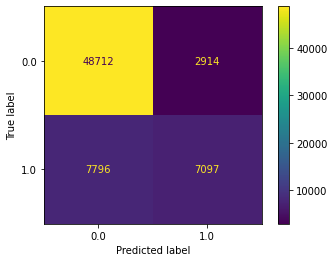

In [37]:
ConfusionMatrixDisplay.from_predictions(Y_train, cross_val_predict(grid.best_estimator_, X_train, Y_train))

Podemos ver que la cantidad de falsos negativos es mas del doble de la cantidad de falsos positivos. Esto se debe a que el dataset se encontraba desbalanceado, por lo que el modelo tiende a devolver 0 con más frecuencia, ya que en las hojas tendrá mayor cantidad de instancias negativas que positivas.

## Cambiando los pesos de las clases

Podemos intentar solucionar el problema anterior modificando el parámetro ***class_weight*** para que modifique la importancia de cada clase de la variable target en funcion de su frecuencia en el dataset

In [38]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(3,15,1),
    "min_samples_leaf": np.arange(100,800,25),
}

grid = GridSearchCV(DecisionTreeClassifier(class_weight="balanced", random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8542981296878718

In [39]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.857091,0.786594,0.516088,0.750094,0.611467


In [40]:
grid_history_table(grid)

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,gini,8,150,0.854298,0.775643,0.499480,0.765192,0.604333
1,gini,8,100,0.854197,0.777883,0.502735,0.756866,0.604121
2,gini,9,200,0.854183,0.769780,0.491416,0.772710,0.600523
3,entropy,9,175,0.854154,0.776109,0.500142,0.763379,0.604276
4,gini,9,150,0.854028,0.770276,0.491850,0.773585,0.601273
...,...,...,...,...,...,...,...,...
667,gini,3,700,0.817297,0.758295,0.474877,0.745516,0.580059
668,gini,3,725,0.817297,0.758295,0.474877,0.745516,0.580059
669,gini,3,775,0.817297,0.758295,0.474877,0.745516,0.580059
670,gini,3,450,0.817297,0.758295,0.474877,0.745516,0.580059


Los mejores modelos resultaron ser más simples (menor profundidad) y mantuvieron el AUC ROC entre los mismos valores (aunque las otras métricas cambiaron)

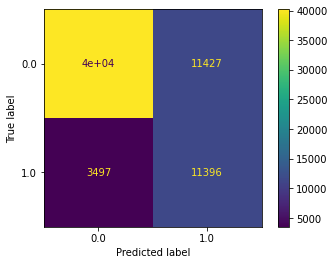

In [41]:
ConfusionMatrixDisplay.from_predictions(Y_train, cross_val_predict(grid.best_estimator_, X_train, Y_train))

Vemos que la cantidad de instancias predichas correctamente disminuyó (lo cual se ve reflejado en la accuracy del modelo)

In [44]:
feature_importances(df_features.columns, grid.best_estimator_.feature_importances_).head(10)

,importancia
feature,
humedad_tarde,0.575663
horas_de_sol,0.162571
presion_atmosferica_tarde,0.124217
rafaga_viento_max_velocidad,0.057604
mm_lluvia_dia,0.025247
sin_viento_temprano,0.008616
sin_viento_tarde,0.008294
nubosidad_tarde,0.007709
temperatura_temprano,0.006102


La importancia de las features se mantuvo similar, aunque algunas aumentaron un poco, como el caso de **sin_viento_temprano**.

El modelo resultante no fue superador, ya que el score no aumentó

In [45]:
dump(grid.best_estimator_, 'DecisionTreeClassifier/balanced.joblib') 

['DecisionTreeClassifier/balanced.joblib']